# Burn severity maps using Sentinel-2 Cloud-Optimised Dataset

# Context
### Purpose
Demonstrate how to fetch satellite Sentinel-2 data to generate burn severity maps for the assessment of the areas affected by wildfires.

### Methodology approach
* Access Sentinel-2 L2A cloud optimised dataset through STAC
* Compute the Normalised Burn Ratio (NBR) index to highlight burned areas
* Classify burn severity

### Highlights
* The NBR index uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths.

### Contributions
#### Notebook
Alejandro Coca-Castro, The Alan Turing Institure, [acocac](https://github.com/acocac) (author)
Michele Claus, Eurac Research, [clausmichele](https://github.com/clausmichele) (reviewer)

#### Related publications
* https://www.sciencedirect.com/science/article/pii/S1470160X22004708#f0035
* https://github.com/yobimania/dea-notebooks/blob/e0ca59f437395f7c9becca74badcf8c49da6ee90/Fire%20Analysis%20Compiled%20Scripts%20(Gadi)/dNBR_full.py

:::{note}
The notebook was prepared using the template of the [Environmental Data Science book](https://github.com/alan-turing-institute/environmental-ds-book)
:::

## Load libraries

In [1]:
!pip -q install odc.stac

In [2]:
import os

from pystac_client import Client
from odc.stac import configure_rio, stac_load
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

## Load data

In [3]:
index_name = 'NBR'

km2deg = 1.0 / 111
x, y = (23.9983519, 37.7351433)  # Center point of a query
r = 4 * km2deg  
bbox = (x - r, y - r, x + r, y + r)
zoom = 1

crs = "epsg:3857"  # projection on which the data will be projected

# Normalised Burn Ratio, Lopez Garcia 1991
index_dict = {'NBR': lambda ds: (ds.nir - ds.swir22) / (ds.nir + ds.swir22)}

## Show location on a map

Text(0.5, 1.0, 'Map of the area of interest')

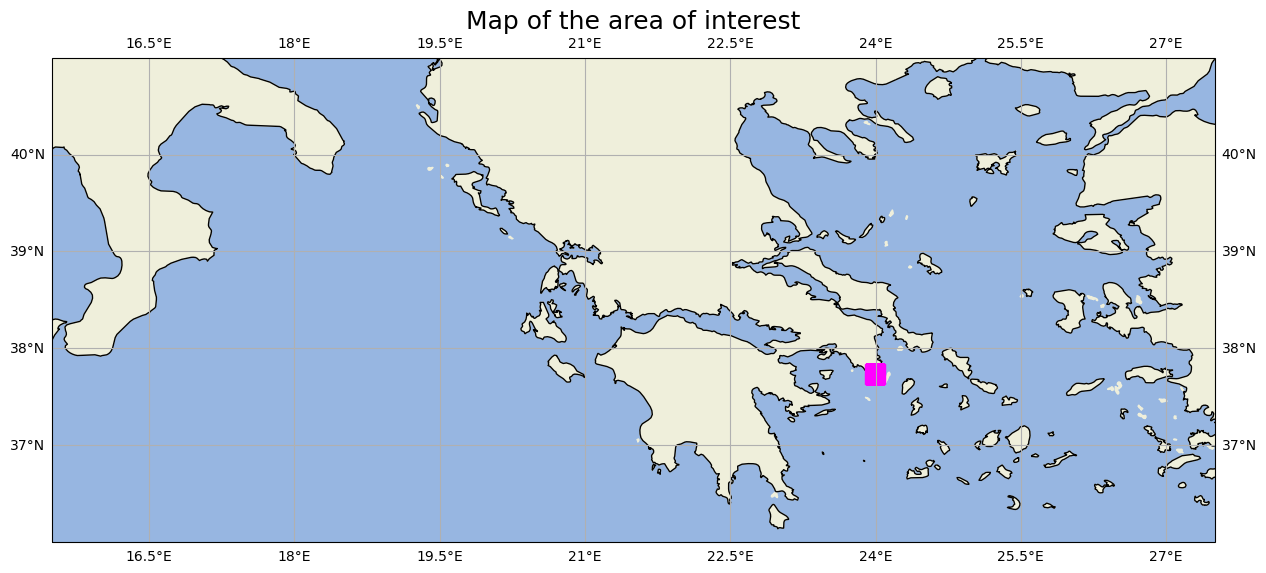

In [4]:
fig = plt.figure(1, figsize=[15, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([15.5, 27.5, 36, 41], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

plt.plot(x, y,
         color='magenta', markersize=15, marker='s',
         transform=ccrs.PlateCarree(),
         )

# One way to customize your title
plt.title("Map of the area of interest", fontsize=18)

## Open Catalog and get data

In [5]:
# Open a catalog
catalog = Client.open("https://earth-search.aws.element84.com/v1")

## Search and get data before the fire
- time_range contains the period over which data will be searched;
- query contains additional requirements e.g. get data only when the cloud cover is low (< 0.5)

In [6]:
# prefire data
time_range = "2021-08-10/2021-08-16"

query1 = catalog.search(
    collections=["sentinel-2-l2a"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}},
)

items = list(query1.get_items())
print(f"Found: {len(items):d} datasets")

items_pre = min(items, key=lambda item: item.properties["eo:cloud_cover"])

prefire_ds = stac_load(
    [items_pre],
    bands=("nir", "swir22"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="datetime",
    bbox=bbox,
)

Found: 2 datasets


## Search and get data after the fire

In [7]:
##postfire
time_range = "2021-08-17/2021-08-20"

query2 = catalog.search(
    collections=["sentinel-2-l2a"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}},
)

items = list(query2.get_items())
print(f"Found: {len(items):d} datasets")

items_post = min(items, key=lambda item: item.properties["eo:cloud_cover"])

postfire_ds = stac_load(
    [items_post],
    bands=("nir", "swir22"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="datetime",
    bbox=bbox,
)

Found: 2 datasets


In [8]:
# prefire
prefire_ds[index_name] = index_dict[index_name](prefire_ds / 10000.0)

# postfire
postfire_ds[index_name] = index_dict[index_name](postfire_ds / 10000.0)

In [9]:
# calculate delta NBR
prefire_burnratio = prefire_ds.NBR.isel(time=0)
postfire_burnratio = postfire_ds.NBR.isel(time=0)

delta_NBR = prefire_burnratio - postfire_burnratio

dnbr_dataset = delta_NBR.to_dataset(name='delta_NBR')

## Outputs

Text(0.5, 1.0, '18 August 2021')

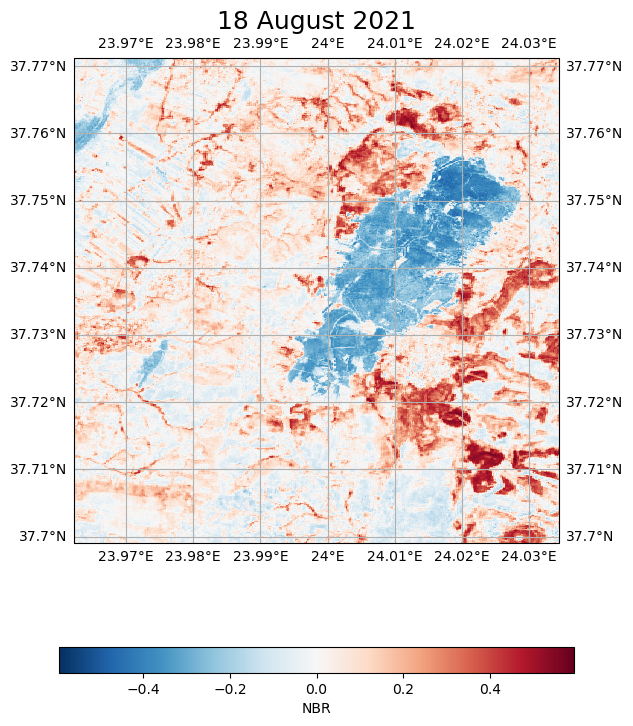

In [10]:
fig = plt.figure(1, figsize=[7, 9])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
postfire_burnratio.plot(ax=ax, transform=ccrs.epsg(postfire_burnratio.spatial_ref.values), cmap='RdBu_r',
                        cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( pd.to_datetime(postfire_burnratio.time.values.item()).strftime("%d %B %Y"), fontsize=18)

Text(0.5, 1.0, 'Delta NBR')

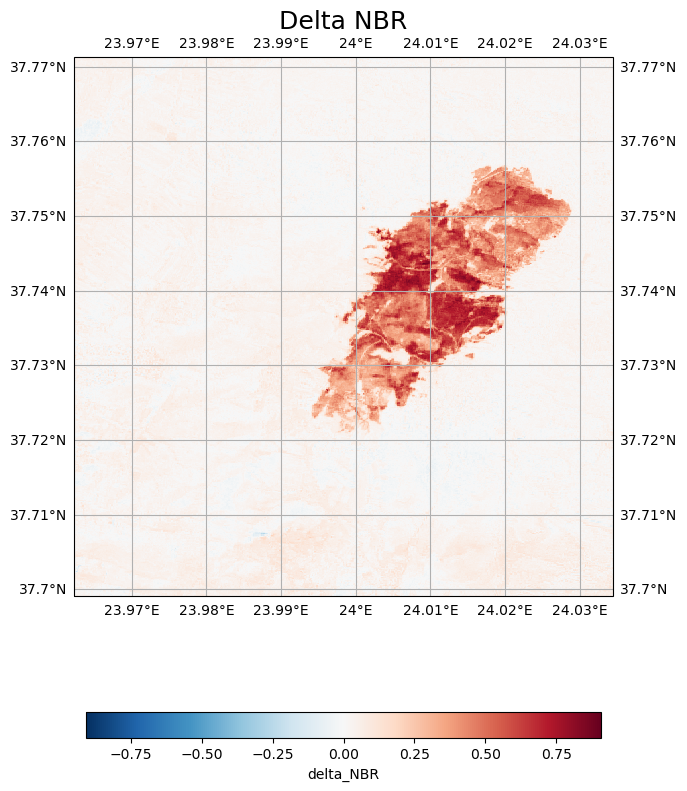

In [11]:
fig = plt.figure(1, figsize=[7, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
dnbr_dataset.delta_NBR.plot(ax=ax, transform=ccrs.epsg(dnbr_dataset.delta_NBR.spatial_ref.values), cmap='RdBu_r',
                            cbar_kwargs={'orientation':'horizontal','shrink':0.95})

# One way to customize your title
plt.title( "Delta NBR", fontsize=18)

## Additional information

**License**: The code in this notebook is licensed under the MIT License.

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to create an issue in the hosting repository or send a direct message to [the notebook author](mailto:acoca@turing.ac.uk).

In [12]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-10-18
